[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


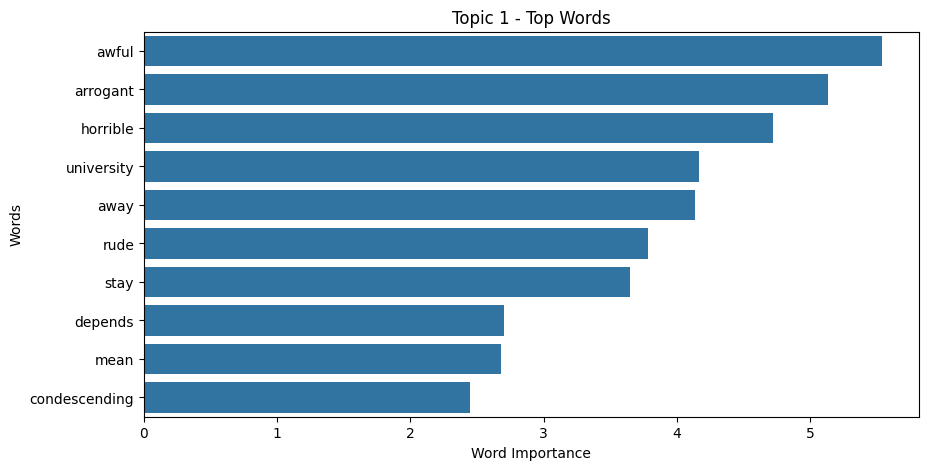

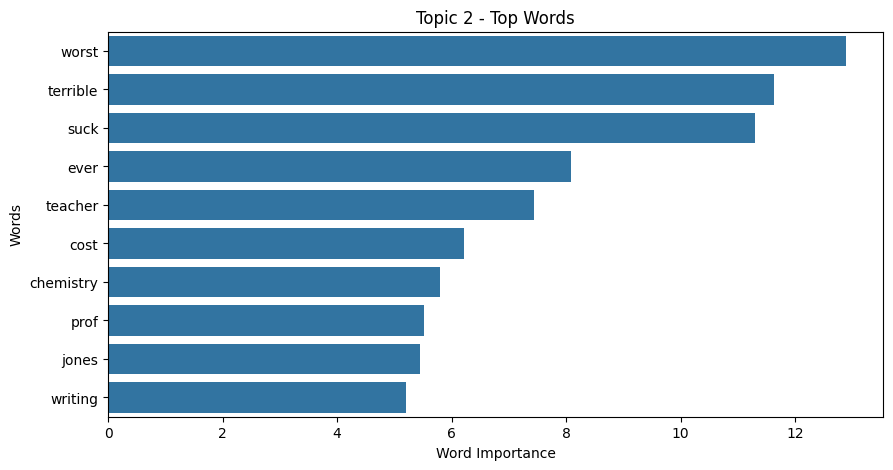

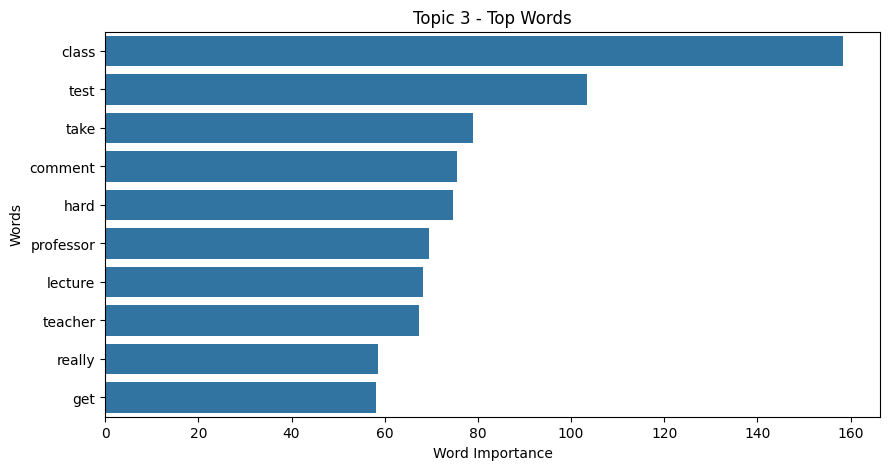

Topic 1: awful, arrogant, horrible, university, away, rude, stay, depends, mean, condescending
Topic 2: worst, terrible, suck, ever, teacher, cost, chemistry, prof, jones, writing
Topic 3: class, test, take, comment, hard, professor, lecture, teacher, really, get


In [ ]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')

def topic_modeling_csv(csv_file_path, column_name, num_topics=3, encoding='latin-1', visualize=True):
    try:
        reviews = pd.read_csv(csv_file_path, encoding=encoding)[column_name].astype(str).tolist()
    except FileNotFoundError:
        return "Error: CSV file not found."
    except KeyError:
        return f"Error: Column '{column_name}' not found."
    except Exception as e:
        return f"An error occurred: {e}"

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    preprocess = lambda text: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text.lower()) if word.isalpha() and word not in stop_words])
    processed_reviews = [preprocess(review.strip()) for review in reviews]

    tfidf = TfidfVectorizer(max_df=0.95, min_df=2).fit_transform(processed_reviews)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42).fit(tfidf)
    feature_names = TfidfVectorizer(max_df=0.95, min_df=2).fit(processed_reviews).get_feature_names_out()

    topics = []
    for i, topic in enumerate(lda.components_):
        top_features_idx = topic.argsort()[:-11:-1] #top 10 words
        top_features = [feature_names[idx] for idx in top_features_idx]
        topics.append(f"Topic {i + 1}: {', '.join(top_features)}")

        if visualize:
            plt.figure(figsize=(10, 5))
            sns.barplot(x=lda.components_[i][top_features_idx], y=top_features)
            plt.title(f"Topic {i + 1} - Top Words")
            plt.xlabel("Word Importance")
            plt.ylabel("Words")
            plt.show()

    return topics

csv_file_path = '/content/feedback student (2).csv'
column_name = 'comment'

result = topic_modeling_csv(csv_file_path, column_name)

if isinstance(result, list):
    for topic in result:
        print(topic)
else:
    print(result)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


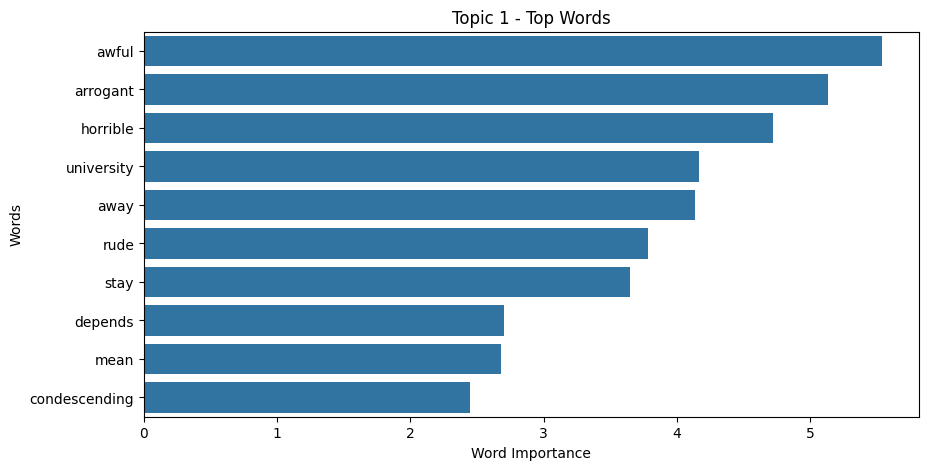

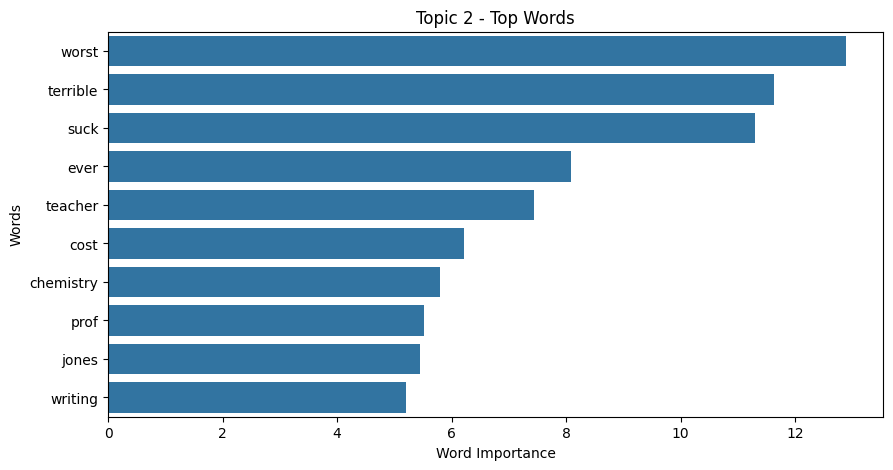

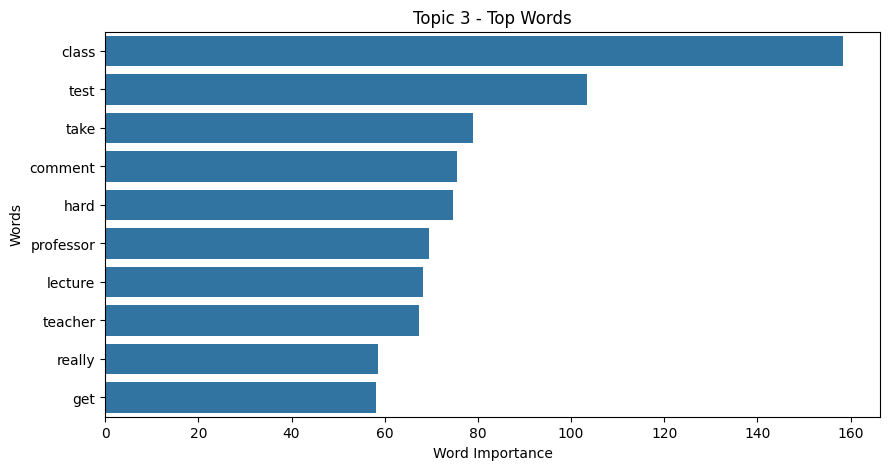

Topic 1: awful, arrogant, horrible, university, away, rude, stay, depends, mean, condescending
Topic 2: worst, terrible, suck, ever, teacher, cost, chemistry, prof, jones, writing
Topic 3: class, test, take, comment, hard, professor, lecture, teacher, really, get

Overall, the student appears to be positive.


In [2]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab')
nltk.download('vader_lexicon', quiet=True)

def topic_modeling_csv(csv_file_path, column_name, num_topics=3, encoding='latin-1', visualize=True):
    try:
        df = pd.read_csv(csv_file_path, encoding=encoding)
        reviews = df[column_name].astype(str).tolist()  # Convert to string and then to list
    except FileNotFoundError:
        return "Error: CSV file not found."
    except KeyError:
        return f"Error: Column '{column_name}' not found."
    except Exception as e:
        return f"An error occurred: {e}"

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer() # Changed this line
    def preprocess(text):
        if isinstance(text, str):  # Check if text is a string
            return ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(text.lower()) if word.isalpha() and word not in stop_words])
        else:
            return ''  # Return empty string for non-string values
    processed_reviews = [preprocess(review.strip()) for review in reviews]

    tfidf = TfidfVectorizer(max_df=0.95, min_df=2).fit_transform(processed_reviews)
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42).fit(tfidf)
    feature_names = TfidfVectorizer(max_df=0.95, min_df=2).fit(processed_reviews).get_feature_names_out()

    topics = []
    for i, topic in enumerate(lda.components_):
        top_features_idx = topic.argsort()[:-11:-1] #top 10 words
        top_features = [feature_names[idx] for idx in top_features_idx]
        topics.append(f"Topic {i + 1}: {', '.join(top_features)}")

        if visualize:
            plt.figure(figsize=(10, 5))
            sns.barplot(x=lda.components_[i][top_features_idx], y=top_features)
            plt.title(f"Topic {i + 1} - Top Words")
            plt.xlabel("Word Importance")
            plt.ylabel("Words")
            plt.show()

    # Sentiment Analysis
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = [sid.polarity_scores(review) for review in reviews]
    df['sentiment_score'] = sentiment_scores #store sentiment scores in df

    # Classify overall sentiment
    def classify_sentiment(score):
        if score['compound'] >= 0.05:
            return 'Positive'
        elif score['compound'] <= -0.05:
            return 'Negative'
        else:
            return 'Neutral'
    df['overall_sentiment'] = df['sentiment_score'].apply(classify_sentiment)
    overall_sentiment = df['overall_sentiment'].value_counts().idxmax() #find the most common sentiment

    return topics, overall_sentiment

csv_file_path = '/content/feedback student (2).csv'
column_name = 'comment'

result = topic_modeling_csv(csv_file_path, column_name)

if isinstance(result, tuple):
    topics, overall_sentiment = result
    for topic in topics:
        print(topic)
    print(f"\nOverall, the student feedback appears to be {overall_sentiment.lower()}.")
elif isinstance(result, str):
    print(result)
